# INTELIGENCIA ARTIFICIAL (1INF24)
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)

# Entrenando y Seleccionando Modelos Simples de Clasificación

In [1]:
# Cargar librerias y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest  # Para seleccionar atributos de forma univariada (filtros)
from sklearn.feature_selection import chi2  # Estadististica para evaluar la importancia de atributos en relacion al target
from sklearn.feature_selection import RFE   # Metodo recursive featute elimination
from sklearn.decomposition import PCA       # Para transformacion PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Para modelos discriminantes lineales
from sklearn.naive_bayes import GaussianNB  # Para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression  # Para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier      # Para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier   # Para modelos Knn
from sklearn.svm import SVC  # Para modelos SVM

from sklearn.model_selection import train_test_split  # Para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # Para partir la data en k-folds
from sklearn.model_selection import cross_val_score  # Para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, balanced_accuracy_score  # Para manejar metricas de desempeño
from sklearn.metrics import classification_report  # Para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # Para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # Indice jacard

Vamos a trabajar con el dataset <b>pima-indians-diabetes</b>.

In [2]:
# Carga el dataset pima-indians-diabetes
filename = 'pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataset = pd.read_csv(filename, names = names)

# Separa el dataset en atributos (X) y target (y)
array = dataset.values
X = array[:, 0:8]  # Atributos
y = array[:, 8]    # Target

# Realiza el train-test split
vadid_fraction = 0.20  # Proporcion de muestras para validacion
seed = 7  # Semilla para el generador aleatorio (para reproductibilidad)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = vadid_fraction, random_state = seed)

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))

Training: 614 ejemplos. Validation: 154 ejemplos


In [3]:
dataset.describe()

,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
# Muestra la distribucion de las clases
print(dataset.groupby('class').size())

class
0    500
1    268
dtype: int64


Es un problema de clasificación con clases desbalanceadas.

### Evalúa diferentes algoritmos de ML en crossvalidación

No sabemos qué algoritmos de ML serán buenos para este problema o qué configuraciones usar.
Vamos a evaluar 4 algoritmos de ML diferentes:

    - Logistic Regression (LR)
    - K-Nearest Neighbors (KNN).
    - Classification and Regression Trees (CART)
    - Support Vector Machines (SVM)

In [5]:
# Definimos el pool de algoritmos de ML a evaluar
algos = []
algos.append(('LogReg', LogisticRegression(solver = 'liblinear')))  # Genera logistic regresors con solver liblinear
algos.append(('5NN', KNeighborsClassifier(n_neighbors = 5)))  # Genera knn con 5 vecinos
algos.append(('10NN', KNeighborsClassifier(n_neighbors = 10)))  # Genera knn con 5 vecinos
algos.append(('CART', DecisionTreeClassifier(max_depth = None)))  # Genera DT sin restriccion de profundidad
algos.append(('SVM', SVC()))  # Genera SVMs con kernel radial (por default)

La evaluación de cada algoritmo se realiza con los datos de training en estrategia de Crossvalidación con 10-folds. Se usa el mismo particionamiento de folds en cada algoritmo a evaluar para asegurar una comparación justa.

La métrica de evaluación es 'balanced_accuracy', esta es el promedio de recalls en cada clase (recall(clase i) = proporción correctamente clasificada como clase i del total de ejemplos de clase i).

In [6]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# Genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits = 10, random_state = seed, shuffle = True)  # Especifica el particionador de datos a 10-folds CV

# Evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv = kfold, scoring = 'balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LogReg: 0.7037331071402841 (0.05720087195942163)
5NN: 0.6704306613451869 (0.0662609974723939)
10NN: 0.6706229314424152 (0.06439208569916693)
CART: 0.6486659292312758 (0.06717734898378894)
SVM: 0.6830105993698966 (0.050731752394481675)


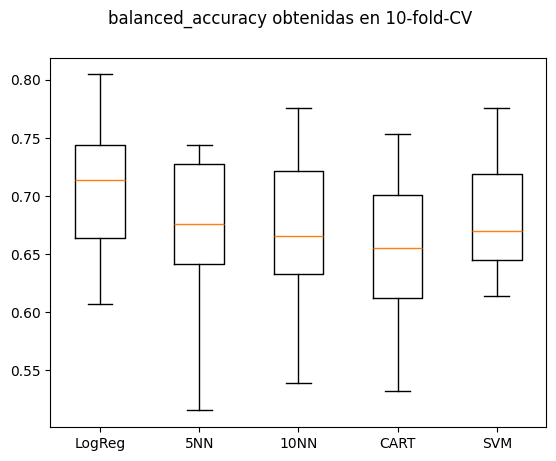

In [7]:
# Muestra graficamente los resultados de balanced_accuracy en crossvalidacion de los algoritmos evaluados
fig = plt.figure()
fig.suptitle('balanced_accuracy obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Entrena el modelo con el algoritmo seleccionado y lo prueba en datos de validación

Ahora entrenaremos un modelo con el mejor algoritmo (LogisticRegression(solver='liblinear')) usando todos los datos de entrenamiento y lo evaluamos en la data separada para validación.

In [8]:
# Reentrena el modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validacion
model = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')  # Usar (class_weight = 'balanced') para entrenar tomando en cuenta el desbalance
model.fit(X_train, y_train)

# Predice la clase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# Muestra la matriz de confusion donde un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de confusión:")
print(confusion_matrix(y_valid, y_predicted))

# Muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificación en conjunto de validación:\n")
print(classification_report(y_valid, y_predicted))

Balanced accuracy score: 0.7864894194248508

Matriz de confusión:
[[76 21]
 [12 45]]

Reporte de clasificación en conjunto de validación:

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82        97
         1.0       0.68      0.79      0.73        57

    accuracy                           0.79       154
   macro avg       0.77      0.79      0.78       154
weighted avg       0.80      0.79      0.79       154



## Pipelines

Si se quiere usar técnicas de pre-procesamiento (escalamiento, normalización, feature selection, feature transformation, etc) es importante que dichos procesos sean hechos en la estrategia de crossvalidación. No se debe hacer la transformación en todo el conjunto de datos disponible y luego aplicar la estrategia de crossvalidación para evaluar modelos porque se incurre en 'data leakage' y las métricas de evaluación serán mejores de lo real. En Sklearn se puede implementar <b> pipelines </b> para evaluar en crossvalidación todo el conjunto de pasos de pre-procesamiento y modelamiento.

Veamos el ejemplo anterior haciendo un MinMaxScaler en los atributos como parte del pipeline de modelamiento:

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

# Definimos el pool de pipleines de ML (MinMaxScaler + algoritmo de ML) a evaluar
pipelines = []
pipelines.append(('LogReg', make_pipeline(MinMaxScaler(), LogisticRegression(solver = 'liblinear'))))
pipelines.append(('5NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors = 5))))
pipelines.append(('10NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors = 10))))
pipelines.append(('CART', make_pipeline(MinMaxScaler(), DecisionTreeClassifier(max_depth = None))))
pipelines.append(('SVM', make_pipeline(MinMaxScaler(), SVC())))

In [10]:
# Evaluamos cada pipeline de ML en estrategia de 10-fold-CV
results = []
names = []

# Genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits = 10, random_state = seed, shuffle = True)  # Especifica el particionador de datos a 10-folds CV

# Evalua cada pipeline en crossvalidacion
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_train, y_train, cv = kfold, scoring = 'balanced_accuracy')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

LogReg: 0.6717251882697398 (0.06931206432555224)
5NN: 0.6707486466836172 (0.05894333111482771)
10NN: 0.6473487056765226 (0.05400344376471425)
CART: 0.6394709503300557 (0.06444281453292255)
SVM: 0.6797774594056751 (0.060334368273400905)


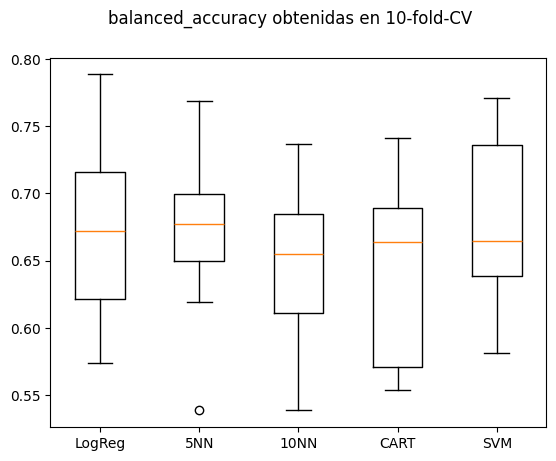

In [11]:
# Muestra graficamente los resultados de balanced_accuracy en crossvalidacion de los pipelines evaluados
fig = plt.figure()
fig.suptitle('balanced_accuracy obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Una vez identificado el pipeline con mejor desempeño entrenamos un modelo con dicho pipeline y toda la data de entrenamiento.

In [13]:
# Reentrena el pipeline LR con todos los datos de entrenamiento y lo prueba en el conjunto de validacion
model = make_pipeline(MinMaxScaler(), LogisticRegression(solver = 'liblinear', class_weight = 'balanced'))  # Usar (class_weight = 'balanced') para entrenar tomando en cuenta el desbalance
model.fit(X_train, y_train)

# Predice la clase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# Muestra la matriz de confusion donde un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de confusión:")
print(confusion_matrix(y_valid, y_predicted))

# Muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificación en conjunto de validación:\n")
print(classification_report(y_valid, y_predicted))

Balanced accuracy score: 0.7849520708988966

Matriz de confusión:
[[74 23]
 [11 46]]

Reporte de clasificación en conjunto de validación:

              precision    recall  f1-score   support

         0.0       0.87      0.76      0.81        97
         1.0       0.67      0.81      0.73        57

    accuracy                           0.78       154
   macro avg       0.77      0.78      0.77       154
weighted avg       0.80      0.78      0.78       154

